# Deep Neural Network for Image Classification

## 0. Connect to Drive

In [10]:
# Authorization

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse4/AACSJCnMU6n0yIYbI-lEicPubk3dsFhv0UU7UyLOOkA43EVeiGo4Icw
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpxwqfqpr3/pubring.gpg' created
gpg: /tmp/tmpxwqfqpr3/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [11]:
import os
print(os.listdir("."))

['datalab', '.config', '.cache', '.forever', '.local', '.gdfuse', '.ipython', 'drive']


In [0]:
# Mount drive to "drive/" folder

!mkdir -p drive
!google-drive-ocamlfuse drive

In [18]:
# Change Working directory

print(os.listdir("drive/Colab/CatImageRecognition/"))
os.chdir("drive/Colab/CatImageRecognition/")
print(os.listdir("."))

['cat-image-recognition.ipynb', 'nn_helpers.py', 'datasets', '__pycache__', 'images', '.ipynb_checkpoints']


## 1. Introduction

In this notebook I am going to implement a Deep Neural Network for Image Classification. This is completely implemented in Numpy and uses binary classification to identify an image as "cat image" or "non-cat image". We first try to use a 2-layered Neural Network, and then an L-layered model.

This was the final project in the course "Neural Networks and Deep Learning" by deeplearning.ai on Coursera taught by Andrew NG which was the first of the 5 course Deep Learning Specialization on Coursera. It was extended by me as I played with the parameters (Look at Result Analysis).

The notebook is divided into following sections -
1. Introduction
2. Load Packages
3. Get the Dataset
4. Two-Layered Model
5. L-Layered Model
6. Result Analysis
7. Test

## 2. Load Packages

In [88]:
!pip install imageio

    100% |████████████████████████████████| 3.3MB 3.7MB/s 


In [94]:
import time
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import transform
import scipy
from nn_helpers import *
# from jupyterthemes import jtplot

# jtplot.style();
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. Get the Dataset

The dataset contains:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

In [0]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

[b'non-cat' b'cat']
y = 0. It's a non-cat picture.


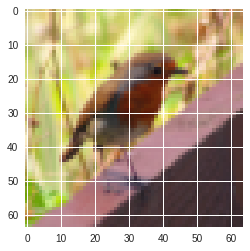

In [22]:
print(classes)
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [23]:
# Exploring the dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of Training examples: " + str(m_train))
print ("Number of Testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of Training examples: 209
Number of Testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [24]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 4. Two Layer Model

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">

<br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***.

<u>Detailed Architecture of the figure</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- The bias term is then added and its relu is taken to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- The same process is repeated.
- The resulting vector is then multiplied by $W^{[2]}$ and the intercept (bias) us added to the result. 
- Finally, the sigmoid of the result is taken. If it is greater than 0.5, it is classified to be a cat.

In [0]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                          # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. 
        # Inputs: X, W1, b1, W2, b2
        # Outputs: A1, cache1, A2, cache2
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation.
        # Inputs: dA2, cache2, cache1
        # Outputs: dA1, dW2, db2; also dA0 (not used), dW1, db1
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Store grads
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [0]:
def run_model_2layer(train_x, train_y, layers_dims, num_iterations, print_cost=True):
 
  parameters = two_layer_model(train_x, train_y, layers_dims=layers_dims, num_iterations=num_iterations, print_cost=print_cost)
  
  # Test accuracy on training set
  print('\n\n Train Set : ')
  predictions_train = predict(train_x, train_y, parameters)
  
  # Test accuracy on test set
  print('\n\n Test Set : ')
  predictions_test = predict(test_x, test_y, parameters)
  
  # Save Model
  np.save('models/nn-2layer-e'+str(num_iterations)+'.npy', parameters)
  
  return parameters

### 4a. Train for 2500 epochs

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.5158304772764731
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.35807050113237976
Cost after iteration 1000: 0.3394281538366413
Cost after iteration 1100: 0.30527536361962654
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.2468176821061484
Cost after iteration 1400: 0.19850735037466105
Cost after iteration 1500: 0.17448318112556638
Cost after iteration 1600: 0.17080762978096967
Cost after iteration 1700: 0.11306524562164705
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726867
Cost after iteration 2000: 0.07439078704319087
Cost after iteration 2100: 0.0663074

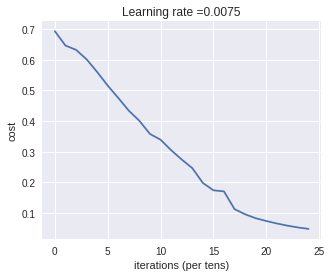



 Train Set : 
Accuracy: 0.9999999999999998


 Test Set : 
Accuracy: 0.72


In [39]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

parameters = run_model_2layer(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

### 4b. Train for 5000 iterations

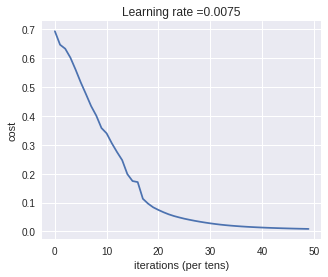



 Train Set : 
Accuracy: 0.9999999999999998


 Test Set : 
Accuracy: 0.7000000000000001


In [46]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

parameters = run_model_2layer(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 5000, print_cost=False)

## 5. L-Layer Model

Here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***

<u>Detailed Architecture</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then the intercept $b^{[1]}$ is added to it. The result is called the linear unit.
- Next, relu of the linear unit is taken. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, sigmoid of the final linear unit is taken. If it is greater than 0.5, it is classified to be a cat.

In [0]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [0]:
def run_model_Llayer(train_x, train_y, layers_dims, num_iterations, print_cost = True):
  
  # Train the model
  parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations=num_iterations, print_cost=print_cost)
  
  # Train Accuracy
  print('\n\nTrain Set : ')
  pred_train = predict(train_x, train_y, parameters)
  
  # Test Accuracy
  print('\n\nTest Set : ')
  pred_test = predict(test_x, test_y, parameters)
  
  # Save the model
  np.save('models/nn-'+str(len(layers_dims)-1)+'layer-e'+str(num_iterations)+'.npy', parameters)
  
  return parameters

### 5a. 4-Layered Model

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


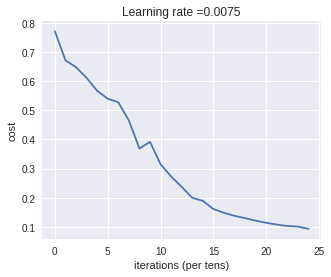



Train Set : 
Accuracy: 0.9856459330143539


Test Set : 
Accuracy: 0.8


In [49]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

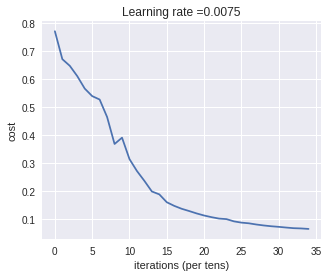



Train Set : 
Accuracy: 0.9904306220095691


Test Set : 
Accuracy: 0.78


In [53]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 3500, print_cost = False)

### 5b. 5-Layered Model

Cost after iteration 0: 0.698928
Cost after iteration 100: 0.643960
Cost after iteration 200: 0.626223
Cost after iteration 300: 0.583023
Cost after iteration 400: 0.553378
Cost after iteration 500: 0.496631
Cost after iteration 600: 0.452853
Cost after iteration 700: 0.416272
Cost after iteration 800: 0.377453
Cost after iteration 900: 0.331324
Cost after iteration 1000: 0.273549
Cost after iteration 1100: 0.236835
Cost after iteration 1200: 0.119576
Cost after iteration 1300: 0.081062
Cost after iteration 1400: 0.061107
Cost after iteration 1500: 0.040391
Cost after iteration 1600: 0.028725
Cost after iteration 1700: 0.021457
Cost after iteration 1800: 0.016782
Cost after iteration 1900: 0.011723
Cost after iteration 2000: 0.008958
Cost after iteration 2100: 0.007040
Cost after iteration 2200: 0.005712
Cost after iteration 2300: 0.004754
Cost after iteration 2400: 0.004044


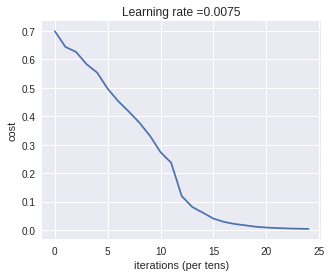



Train Set : 
Accuracy: 0.9999999999999998


Test Set : 
Accuracy: 0.7


In [50]:
# Going 1 layer deeper
### CONSTANTS ###
layers_dims = [12288, 40, 20, 7, 5, 1] #  5-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.698928
Cost after iteration 100: 0.643960
Cost after iteration 200: 0.626223
Cost after iteration 300: 0.583023
Cost after iteration 400: 0.553378
Cost after iteration 500: 0.496631
Cost after iteration 600: 0.452853
Cost after iteration 700: 0.416272
Cost after iteration 800: 0.377453
Cost after iteration 900: 0.331324
Cost after iteration 1000: 0.273549
Cost after iteration 1100: 0.236835
Cost after iteration 1200: 0.119576
Cost after iteration 1300: 0.081062
Cost after iteration 1400: 0.061107


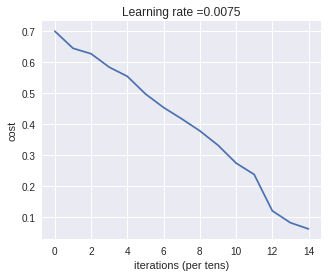



Train Set : 
Accuracy: 0.9952153110047844


Test Set : 
Accuracy: 0.74


In [51]:
### CONSTANTS ###
layers_dims = [12288, 40, 20, 7, 5, 1] #  5-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 1500, print_cost = True)

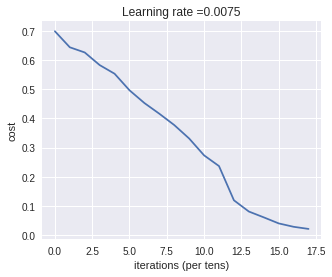



Train Set : 
Accuracy: 0.9952153110047844


Test Set : 
Accuracy: 0.72


In [54]:
### CONSTANTS ###
layers_dims = [12288, 40, 20, 7, 5, 1] #  5-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 1800, print_cost = False)

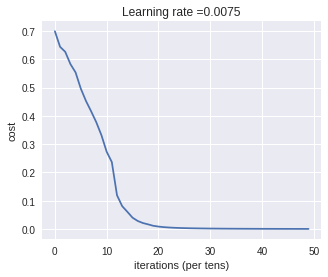



Train Set : 
Accuracy: 0.9999999999999998


Test Set : 
Accuracy: 0.72


In [56]:
### CONSTANTS ###
layers_dims = [12288, 40, 20, 7, 5, 1] #  5-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 5000, print_cost = False)

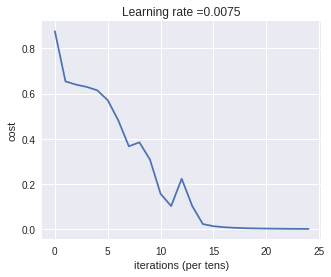



Train Set : 
Accuracy: 0.9999999999999998


Test Set : 
Accuracy: 0.78


In [59]:
### CONSTANTS ###
layers_dims = [12288, 64, 20, 7, 5, 1] #  5-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = False)

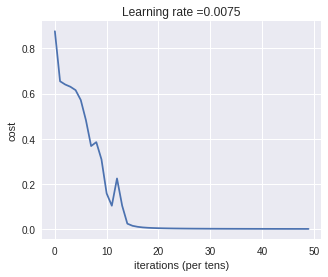



Train Set : 
Accuracy: 0.9999999999999998


Test Set : 
Accuracy: 0.74


In [60]:
### CONSTANTS ###
layers_dims = [12288, 64, 20, 7, 5, 1] #  5-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 5000, print_cost = False)

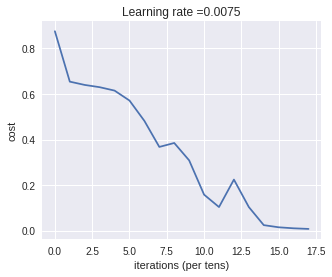



Train Set : 
Accuracy: 0.9999999999999998


Test Set : 
Accuracy: 0.76


In [66]:
### CONSTANTS ###
layers_dims = [12288, 64, 20, 7, 5, 1] #  5-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 1800, print_cost = False)

### 5c. 6-Layered Model

Cost after iteration 0: 0.696853
Cost after iteration 100: 0.673693
Cost after iteration 200: 0.657359
Cost after iteration 300: 0.636461
Cost after iteration 400: 0.607569
Cost after iteration 500: 0.565892
Cost after iteration 600: 0.509969
Cost after iteration 700: 0.449171
Cost after iteration 800: 0.363918
Cost after iteration 900: 0.343432
Cost after iteration 1000: 0.295882
Cost after iteration 1100: 0.320298
Cost after iteration 1200: 0.192528
Cost after iteration 1300: 0.171120
Cost after iteration 1400: 0.598935
Cost after iteration 1500: 0.412720
Cost after iteration 1600: 0.107742
Cost after iteration 1700: 0.067705
Cost after iteration 1800: 0.739435
Cost after iteration 1900: 0.570552
Cost after iteration 2000: 0.517261
Cost after iteration 2100: 0.428040
Cost after iteration 2200: 0.138938
Cost after iteration 2300: 0.072531
Cost after iteration 2400: 0.029933


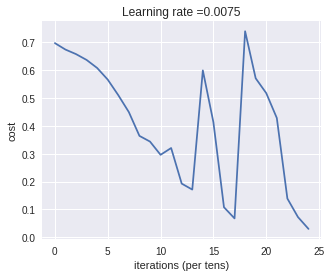



Train Set : 
Accuracy: 0.9999999999999998


Test Set : 
Accuracy: 0.72


In [61]:
# Adding another layer
### CONSTANTS ###
layers_dims = [12288, 120, 40, 20, 7, 5, 1] #  6-layer model

parameters = run_model_Llayer(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

## 6 - Result Analysis

In [0]:
# Loading the best model
parameters = np.load('models/nn-4layer-e2500.npy')

In [0]:
parameters = parameters.item()

In [83]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


As we saw, this was the results of the experiments.
<table>
    <tr>
        <th>Layers</th>
        <th>Layer Dimensions</th>
        <th>Learning Rate</th>
        <th>Iterations</th>
        <th>Train Accuracy</th>
        <th>Test Accuracy</th>
    </tr>
    <tr>
        <td>2</td>
        <td>[12288, 7, 1]</td>
        <td>0.0075</td>
        <td>2500</td>
        <td>0.9999999999999998</td>
        <td>0.72</td>
    </tr>
  <tr>
        <td>2</td>
        <td>[12288, 7, 1]</td>
        <td>0.0075</td>
        <td>5000</td>
        <td>0.9999999999999998</td>
        <td>0.70</td>
    </tr>
    <tr>
        <td>4</td>
        <td>[12288, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>2500</td>
        <td>0.9856459330143539</td>
        <td>0.8</td>
    </tr>
    <tr>
        <td>4</td>
        <td>[12288, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>3500</td>
        <td>0.9904306220095691</td>
        <td>0.78</td>
    </tr>
    <tr>
        <td>5</td>
        <td>[12288, 40, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>2500</td>
        <td>0.9999999999999998</td>
        <td>0.7</td>
    </tr>
    <tr>
        <td>5</td>
        <td>[12288, 40, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>1500</td>
        <td>0.9952153110047844</td>
        <td>0.74</td>
    </tr>
    <tr>
        <td>5</td>
        <td>[12288, 40, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>1800</td>
        <td>0.9952153110047844</td>
        <td>0.72</td>
    </tr>
    <tr>
        <td>5</td>
        <td>[12288, 40, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>1800</td>
        <td>0.9999999999999998</td>
        <td>0.72</td>
    </tr>
    <tr>
        <td>5</td>
        <td>[12288, 64, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>2500</td>
        <td>0.9999999999999998</td>
        <td>0.78</td>
    </tr>
    <tr>
        <td>5</td>
        <td>[12288, 64, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>5000</td>
        <td>0.9999999999999998</td>
        <td>0.74</td>
    </tr>
    <tr>
        <td>5</td>
        <td>[12288, 64, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>1800</td>
        <td>0.9999999999999998</td>
        <td>0.76</td>
    </tr>
    <tr>
        <td>6</td>
        <td>[12288, 120, 40, 20, 7, 5, 1]</td>
        <td>0.0075</td>
        <td>2500</td>
        <td>0.9999999999999998</td>
        <td>0.72</td>
    </tr>
</table>

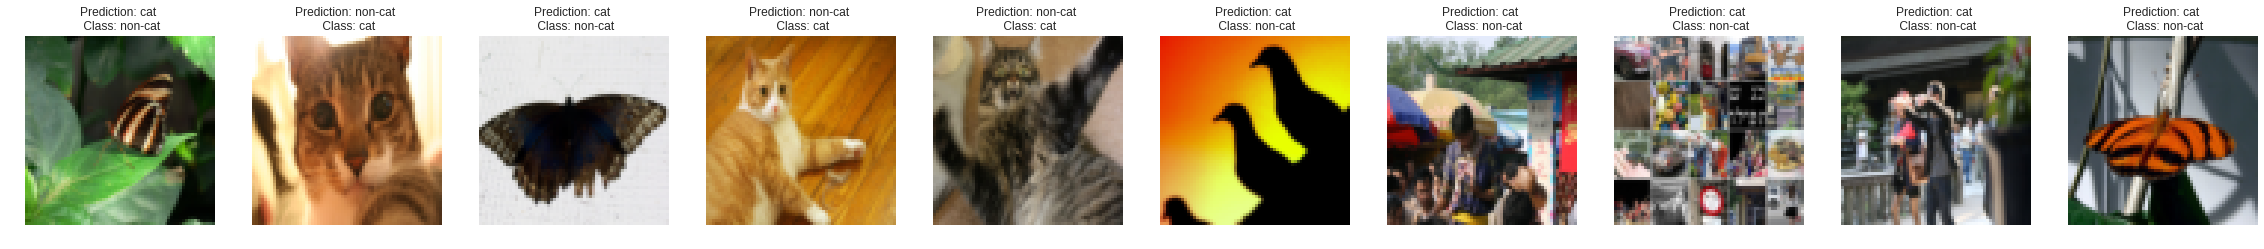

In [84]:
# Mislabeled images
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

## 7 - Test an Image

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


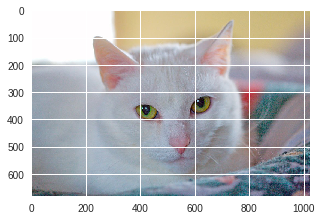

In [95]:
# I used parameters from 4-Layered model to run this
my_image = "my_image.jpg"   # change this to the name of your image file 
my_label_y = [1]            # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
# image = np.array(plt.imread(fname))
image = np.array(imageio.imread(fname))
# my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

# END OF NOTEBOOK